Fold Number : 0 
Accuracy :  0.7333333333333333
Specificity :  0.47619047619047616
Sensitivity :  0.8779761904761905
Precision:  0.748730964467005
F1-Score:  0.8082191780821917
FP:  99
FN:  41
TP:  295
TN:  90 

Fold Number : 1 
Accuracy :  0.6780952380952381
Specificity :  0.48148148148148145
Sensitivity :  0.7886904761904762
Precision:  0.7300275482093664
F1-Score:  0.7582260371959944
FP:  98
FN:  71
TP:  265
TN:  91 

Fold Number : 2 
Accuracy :  0.7085714285714285
Specificity :  0.40425531914893614
Sensitivity :  0.8783382789317508
Precision:  0.7254901960784313
F1-Score:  0.7946308724832215
FP:  112
FN:  41
TP:  296
TN:  76 

Fold Number : 3 
Accuracy :  0.6742857142857143
Specificity :  0.44148936170212766
Sensitivity :  0.8041543026706232
Precision:  0.7207446808510638
F1-Score:  0.7601683029453016
FP:  105
FN:  66
TP:  271
TN:  83 

Fold Number : 4 
Accuracy :  0.7104761904761905
Specificity :  0.3404255319148936
Sensitivity :  0.9169139465875371
Precision:  0.7136258660508084


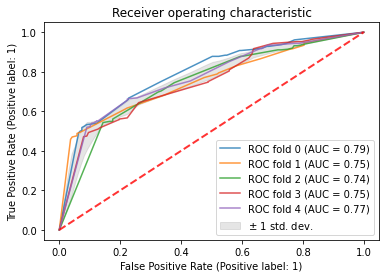

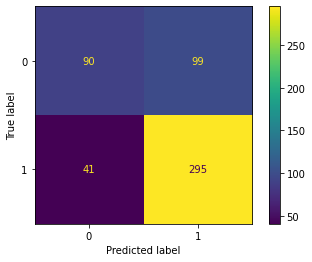

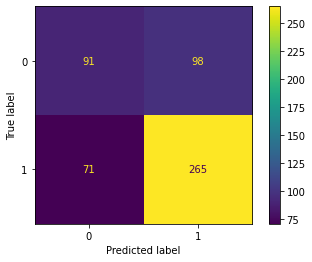

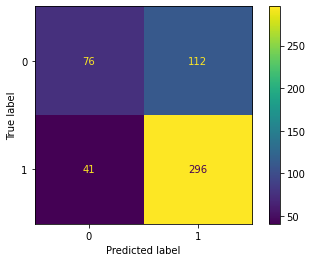

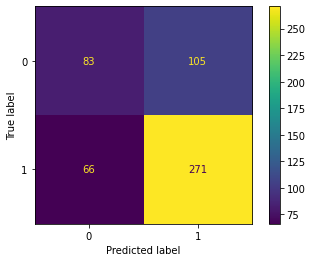

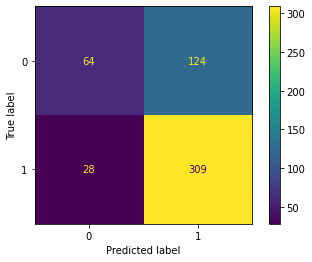

In [17]:
import numpy as np
import csv
from sklearn import metrics,utils
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm, datasets
from sklearn.metrics import auc 
from sklearn.metrics import plot_roc_curve, confusion_matrix , roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression 
import pickle

def load_my_dataset(dataset):
    with open(dataset) as csv_file:
        data_file = csv.reader(csv_file)
        feature = []
        result = []
        for row in data_file:
            try:
                feature.append([float(row[0]), float(row[1])])
                result.append(int(row[2]))
            except ValueError:
                pass
        data = np.asarray(feature)
        target = np.asarray(result)
        feature_names = ['CDR', 'Exudate_Pixel']
        target_names = ['other','non other']

    return utils.Bunch(data=data, target=target, feature_names = feature_names, target_names = target_names)



# Import some data to play with
data = load_my_dataset('Other_nonOther.csv')
X,y = data.data, data.target
n_samples, n_features = X.shape

acc_fold = []
model = []
predict = []
true = []
proba = []

SEED = 1
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle=True)
classifier = DecisionTreeClassifier(max_depth=10,random_state=SEED)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,random_state=100)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train[train], y_train[train])
    viz = plot_roc_curve(classifier, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.8, lw=1.5, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    model.append(classifier)
    y_pred = classifier.predict(X_train[test])
    predict.append(y_pred)
    proba.append(classifier.predict_proba(X_train[test]))
    true.append(y_train[test])

    conf_matrix = confusion_matrix(y_train[test], y_pred)
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    Accuracy = (TP+TN)/(TP+FP+FN+TN)
    acc_fold.append(Accuracy)
    Specificity = TN/(TN+FP)
    sensitivity = TP / (TP + FN) ##recall
    Precision = TP / (TP+FP)
    F1 = 2*((Precision * sensitivity)/(Precision + sensitivity))

    acc_fold.append(Accuracy)

    print('Fold Number : %i ' %i )
    print('Accuracy : ',Accuracy)
    print('Specificity : ',Specificity)
    print('Sensitivity : ',sensitivity)
    print("Precision: ",Precision )
    print("F1-Score: ", F1)
    
    print("FP: ",FP)
    print("FN: ",FN)
    print("TP: ",TP)
    print("TN: ",TN,'\n')
    metrics.plot_confusion_matrix(classifier, X_train[test], y_train[test])
    
    

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
#ax.plot(mean_fpr, mean_tpr, color='b',
        #label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        #lw=1, alpha=.6)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

plt.show()


Accuracy :  0.6952054794520548
Specificity :  0.37037037037037035
Sensitivity :  0.8858695652173914
Precision:  0.7056277056277056
F1-Score:  0.7855421686746988
FP:  68
FN:  21
TP:  163
TN:  40 



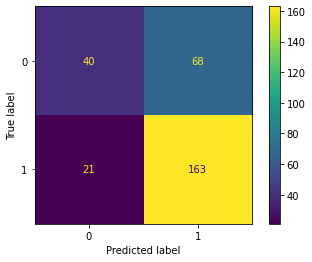

In [18]:
best_model = model[acc_fold.index(max(acc_fold))]
test_model = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, test_model)
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
Accuracy = (TP+TN)/(TP+FP+FN+TN)
acc_fold.append(Accuracy)
Specificity = TN/(TN+FP)
sensitivity = TP / (TP + FN) ##recall
Precision = TP / (TP+FP)
F1 = 2*((Precision * sensitivity)/(Precision + sensitivity))


print('Accuracy : ',Accuracy)
print('Specificity : ',Specificity)
print('Sensitivity : ',sensitivity)
print("Precision: ",Precision )
print("F1-Score: ", F1)
    
print("FP: ",FP)
print("FN: ",FN)
print("TP: ",TP)
print("TN: ",TN,'\n')
metrics.plot_confusion_matrix(classifier, X_test, y_test)